# Plant Disease Detection - Classification using DenseNet121

## Introduction

This notebook focuses on the classification part of a computer vision project aimed at detecting plant diseases from leaf images.

The goal is to build a model that can automatically classify whether a plant leaf is healthy or infected with a specific disease using transfer learning. Early detection of plant diseases is critical in agriculture to prevent crop loss and improve productivity.

## What You'll See in This Notebook

- Use of the **PlantVillage dataset**, which contains thousands of labeled images of healthy and diseased plant leaves.
- Application of **transfer learning** using the VGG16, DenseNet121 models, pretrained on ImageNet.
- Preprocessing of the data using data augmentation and normalization.
- Training a classifier on selected plant disease categories.
- Evaluating model performance and making predictions on new data.

This classification model will later work alongside a segmentation model to highlight infected areas, making this part of a more comprehensive plant disease detection pipeline.


<div>
<strong>Example of Healthy and Unhealthy Leaf</strong>
</div>

<div style="text-align: center;">
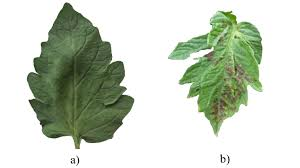
</div>

## Importing necessary libraries

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix

## Data Loading

In [17]:
# Image Size (Suitable with VGG16 and DenseNet121):

IMAGE_SIZE = (224,224)
root_path = '/kaggle/input/plantdisease/PlantVillage'

In [3]:
# Different Classes

l = os.listdir(root_path)

print(f"\n{len(l)} classes")
print(l)


15 classes
['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus']


In [4]:
def load_data(root_path, img_size):
    """
    A method that loads image data from a specified source, resizes each image to a uniform shape,
    and applies normalization to scale pixel values to the desired range [0, 1].
    """ 
    
    images = []
    labels = []
    
    for subfolder in tqdm(os.listdir(root_path), desc = "Loading..."):
        subfolder_path = os.path.join(root_path, subfolder)
        
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)
            image = cv2.imread(image_path)
            
            if image is not None:
                image = cv2.resize(image, img_size)
                image = image.astype('float32') / 255.0
                images.append(image)
                labels.append(subfolder)
                
    return np.array(images), np.array(labels)

In [5]:
# Loading data:

x, y = load_data(root_path, IMAGE_SIZE)

Loading...: 100%|██████████| 15/15 [03:23<00:00, 13.53s/it]


In [6]:
# Shapes

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (20638, 224, 224, 3)
y shape: (20638,)


In [7]:
# Sample Image:

print(y[0])
print(x[0])

Pepper__bell___Bacterial_spot
[[[0.6431373  0.6156863  0.6431373 ]
  [0.6392157  0.6117647  0.6392157 ]
  [0.61960787 0.5921569  0.61960787]
  ...
  [0.52156866 0.5058824  0.54901963]
  [0.49803922 0.48235294 0.5294118 ]
  [0.57254905 0.5568628  0.6039216 ]]

 [[0.62352943 0.59607846 0.62352943]
  [0.627451   0.6        0.627451  ]
  [0.65882355 0.6313726  0.65882355]
  ...
  [0.53333336 0.5176471  0.5647059 ]
  [0.5294118  0.5137255  0.56078434]
  [0.43137255 0.41568628 0.4627451 ]]

 [[0.6392157  0.6117647  0.6392157 ]
  [0.6392157  0.6117647  0.6392157 ]
  [0.6156863  0.5882353  0.6156863 ]
  ...
  [0.49803922 0.48235294 0.5294118 ]
  [0.5411765  0.5254902  0.57254905]
  [0.4745098  0.45882353 0.5058824 ]]

 ...

 [[0.62352943 0.60784316 0.6509804 ]
  [0.62352943 0.60784316 0.6509804 ]
  [0.627451   0.6117647  0.654902  ]
  ...
  [0.52156866 0.5137255  0.56078434]
  [0.50980395 0.5019608  0.54901963]
  [0.48235294 0.4745098  0.52156866]]

 [[0.6117647  0.59607846 0.6392157 ]
  [0.61

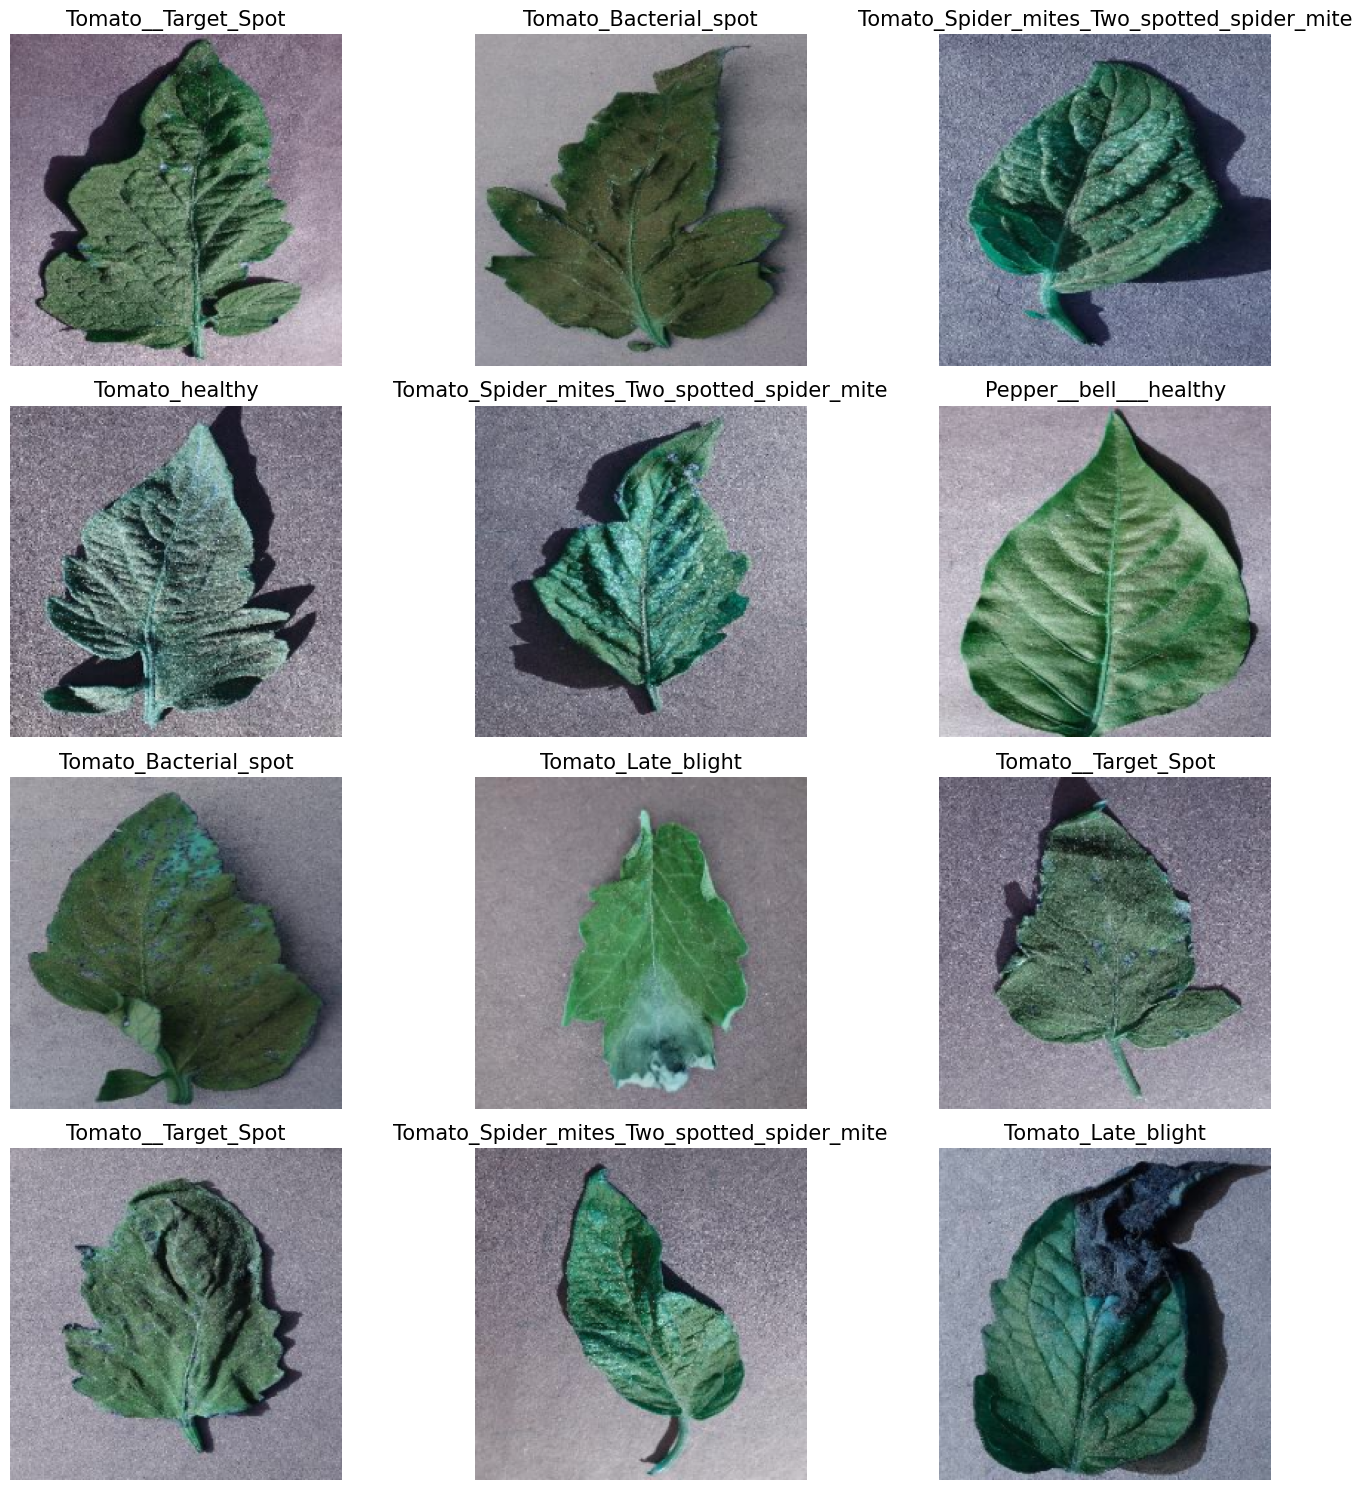

In [9]:
# Visualizing some images:

random_indices = random.sample(range(len(x)), 12)

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    plt.subplot(4, 3, i + 1) 
    plt.imshow(x[idx])
    plt.title(y[idx], fontsize=15)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Data Preprocessing

In [8]:
# Data Splitting:

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 42)

In [9]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"\nx_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

x_train shape: (16510, 224, 224, 3)
y_train shape: (16510,)

x_val shape: (4128, 224, 224, 3)
y_val shape: (4128,)


In [10]:
# Deleting x,y for memory management:

del x, y

In [11]:
# Label Encoding:

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

In [12]:
# Labels Mapping:

print("Classes:", le.classes_)
print("\nLabels Mapping:")
for i, class_label in enumerate(le.classes_):
    print(f"{i} → {class_label}")

Classes: ['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']

Labels Mapping:
0 → Pepper__bell___Bacterial_spot
1 → Pepper__bell___healthy
2 → Potato___Early_blight
3 → Potato___Late_blight
4 → Potato___healthy
5 → Tomato_Bacterial_spot
6 → Tomato_Early_blight
7 → Tomato_Late_blight
8 → Tomato_Leaf_Mold
9 → Tomato_Septoria_leaf_spot
10 → Tomato_Spider_mites_Two_spotted_spider_mite
11 → Tomato__Target_Spot
12 → Tomato__Tomato_YellowLeaf__Curl_Virus
13 → Tomato__Tomato_mosaic_virus
14 → Tomato_healthy


In [13]:
# Classes Distribution:

counter = Counter(y_train)
print(counter)

Counter({'Tomato__Tomato_YellowLeaf__Curl_Virus': 2528, 'Tomato_Bacterial_spot': 1710, 'Tomato_Late_blight': 1522, 'Tomato_Septoria_leaf_spot': 1401, 'Tomato_Spider_mites_Two_spotted_spider_mite': 1365, 'Tomato_healthy': 1265, 'Pepper__bell___healthy': 1172, 'Tomato__Target_Spot': 1130, 'Pepper__bell___Bacterial_spot': 818, 'Tomato_Early_blight': 807, 'Potato___Early_blight': 803, 'Tomato_Leaf_Mold': 792, 'Potato___Late_blight': 778, 'Tomato__Tomato_mosaic_virus': 296, 'Potato___healthy': 123})


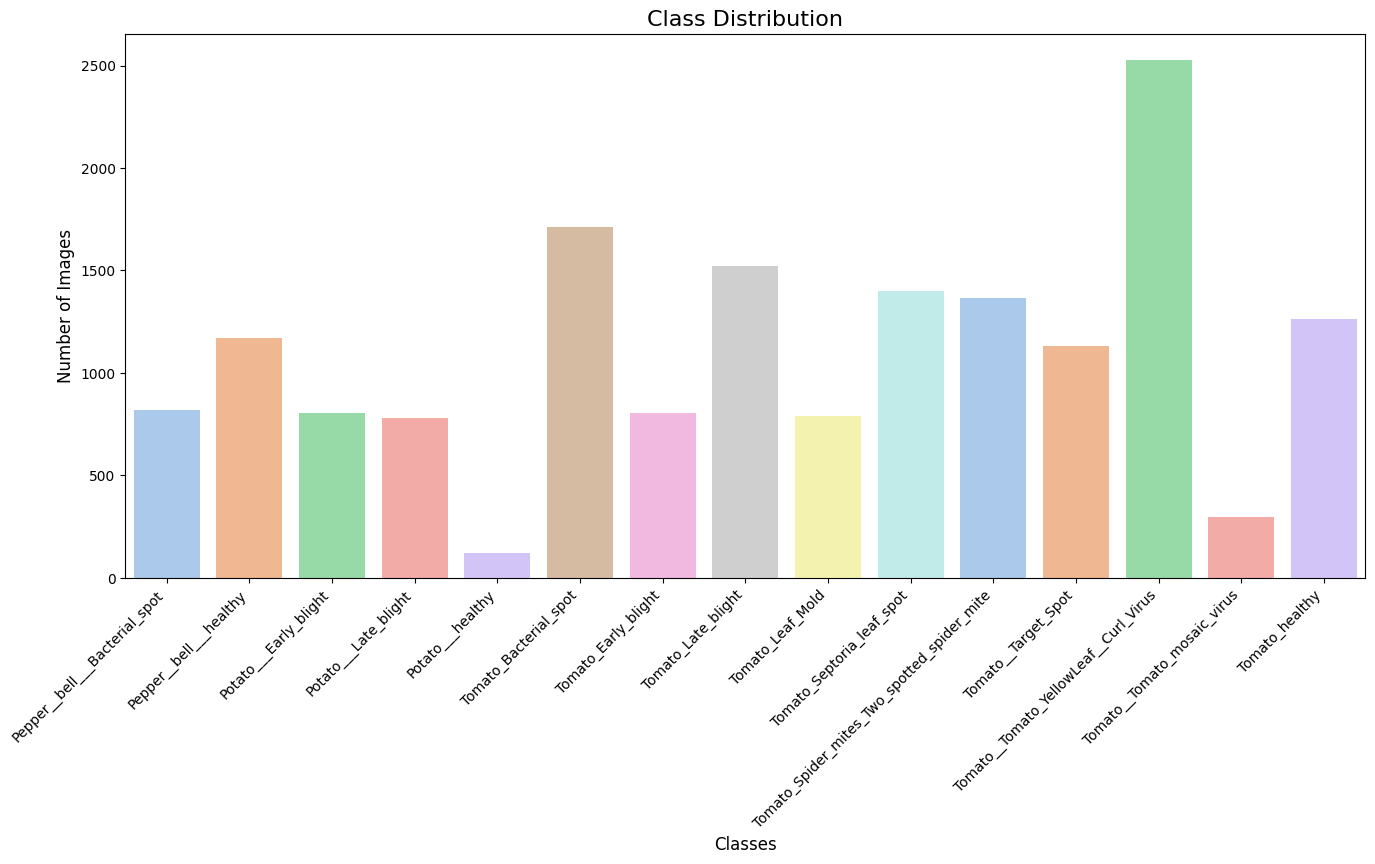

In [15]:
# Plotting the distribution:

labels = list(counter.keys())

plt.figure(figsize=(16, 8))
ax = sns.countplot(x=y_train, order=sorted(labels), palette='pastel')
plt.title("Class Distribution", fontsize=16)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)
plt.show()

Here we notice that classes are imbalanced
> Data augmentation is needed

In [14]:
# Data Augmentation:

train_data_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = False,
    fill_mode='nearest'
)

val_data_gen = ImageDataGenerator()

In [15]:
train_augmented = train_data_gen.flow(x_train, y_train_encoded,
                                      batch_size=32, 
                                      shuffle=True)

val_augmented = val_data_gen.flow(x_val, y_val_encoded,
                                  batch_size=32, 
                                  shuffle=False)  # No shuffling for consistient results. 

*We'll experiment with various models like **VGG16** and **DenseNet121** and select the one that performs best.*

## VGG16

### *Building and Training*

In [23]:
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (224, 224, 3))

In [19]:
# Freezing all layers:

for layer in base_model.layers:
    layer.trainable = False

In [20]:
VGG_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(15, activation = 'softmax')
])

In [21]:
VGG_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,142,351 (80.65 MB)

 Trainable params: 6,427,151 (24.52 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

In [16]:
# CALLBACK 1:

checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath = os.path.join(checkpoint_dir, 'best_classification_model.h5'),
    monitor = 'val_accuracy',  
    save_best_only = True,         
    save_weights_only = False,      
    mode = 'max',                  
    verbose = 1)

# CALLBACK 2:

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = 0.001,
    patience = 8,
    verbose = 1,
    restore_best_weights = True)

# CALLBACK 3:

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 3,
                                            verbose=1,
                                            factor=0.3, 
                                            min_lr=0.000001)

CALLBACKS = [checkpoint, early_stopping, learning_rate_reduction]

In [24]:
opt = Adam(learning_rate=0.001)

VGG_model.compile(optimizer = opt,
                  loss = 'SparseCategoricalCrossentropy',
                  metrics = ['accuracy'])

In [ ]:
epoch = 20

VGG_History = VGG_model.fit(train_augmented,
                            validation_data = val_augmented,
                            epochs = epoch,
                            callbacks = CALLBACKS)

In [ ]:
os.makedirs('results', exist_ok=True)

VGG_model.save('results/best_classification_model.h5')
VGG_model.save_weights('results/best_classification_model_weights.weights.h5')

### *Evaluation*

In [19]:
VGG_model = load_model('/kaggle/working/results/best_classification_model.h5')

In [27]:
VGG_model.evaluate(x_val,y_val_encoded)

129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.9339 - loss: 0.2225


[0.21141327917575836, 0.932170569896698]

In [21]:
y_pred = np.argmax(VGG_model.predict(x_val), axis=1)
y_pred

129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step


array([10, 10, 14, ..., 12, 12, 11])

In [24]:
le.classes_

array(['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy',
       'Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight',
       'Tomato_Late_blight', 'Tomato_Leaf_Mold',
       'Tomato_Septoria_leaf_spot',
       'Tomato_Spider_mites_Two_spotted_spider_mite',
       'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus',
       'Tomato__Tomato_mosaic_virus', 'Tomato_healthy'], dtype='<U43')

In [25]:
print(classification_report(y_val_encoded, y_pred, target_names = le.classes_))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.96      0.97       179
                     Pepper__bell___healthy       0.97      0.99      0.98       306
                      Potato___Early_blight       0.99      0.96      0.98       197
                       Potato___Late_blight       0.92      0.97      0.94       222
                           Potato___healthy       0.84      0.90      0.87        29
                      Tomato_Bacterial_spot       0.96      0.97      0.97       417
                        Tomato_Early_blight       0.96      0.68      0.80       193
                         Tomato_Late_blight       0.94      0.86      0.90       387
                           Tomato_Leaf_Mold       0.88      0.88      0.88       160
                  Tomato_Septoria_leaf_spot       0.90      0.96      0.93       370
Tomato_Spider_mites_Two_spotted_spider_mite       0.77      1.00

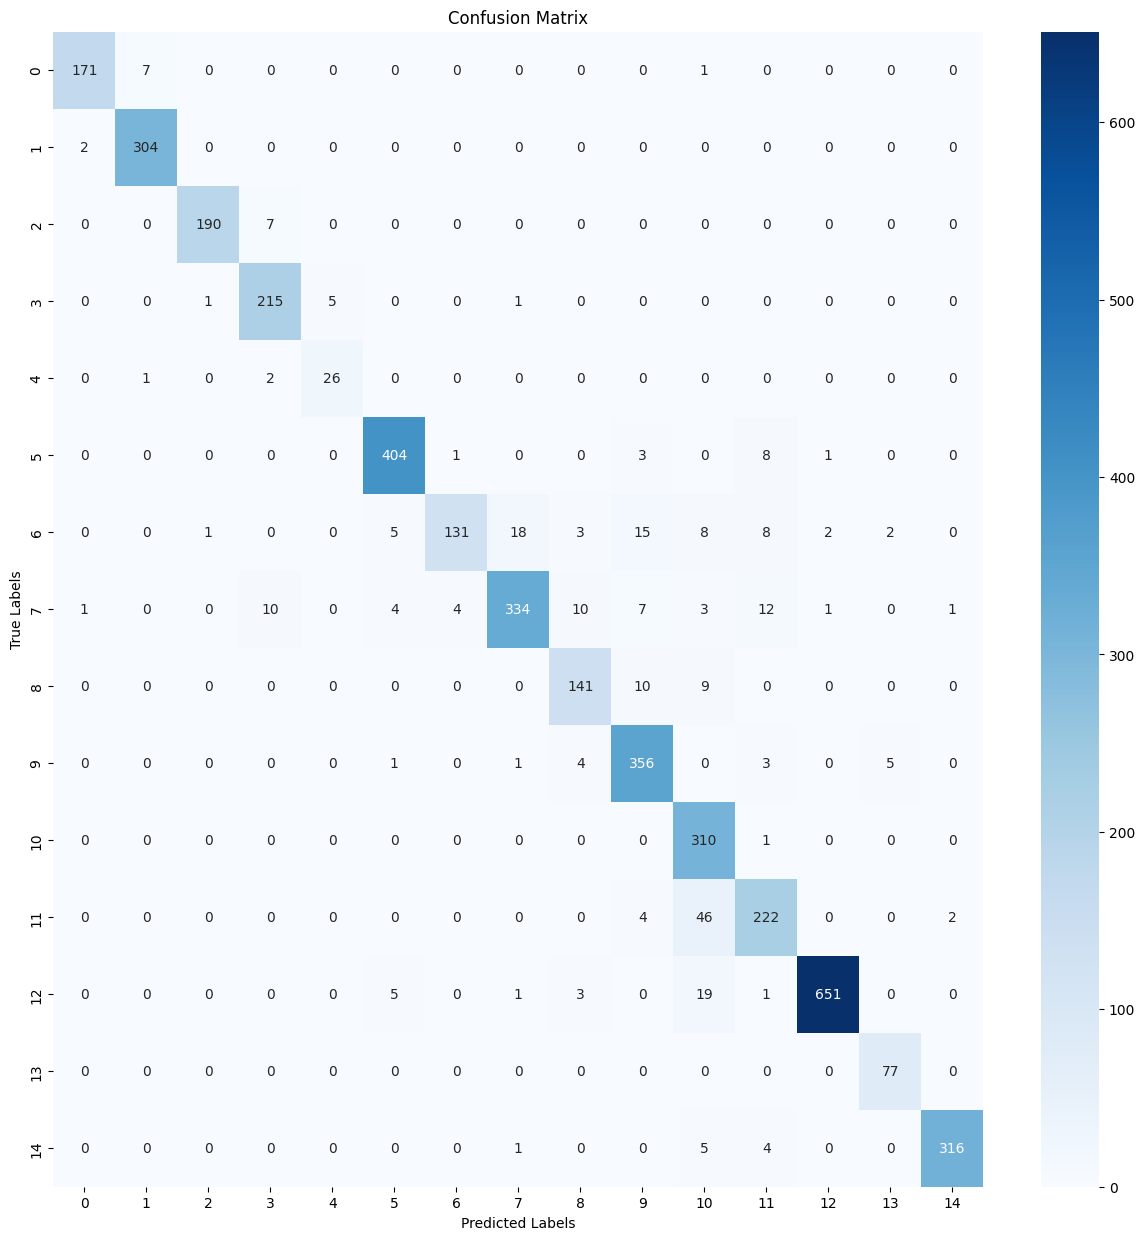

In [29]:
cm = confusion_matrix(y_val_encoded, y_pred)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## DenseNet121 

### *Building and Training*

In [19]:
base_model_1 = DenseNet121(include_top=False,
                           weights='imagenet',
                           input_shape=(224, 224, 3))

I0000 00:00:1753205583.592502      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753205583.593244      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# Freezing all layers:

for layer in base_model_1.layers:
    layer.trainable = False

In [23]:
DenseNet_model = Sequential([
    base_model_1,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

In [24]:
DenseNet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,304,783 (27.87 MB)

 Trainable params: 266,767 (1.02 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

In [25]:
opt = Adam(learning_rate=0.001)

DenseNet_model.compile(optimizer = opt,
                       loss = 'SparseCategoricalCrossentropy',
                       metrics = ['accuracy'])

In [26]:
epoch = 20

DenseNet_History = DenseNet_model.fit(train_augmented,
                                      validation_data = val_augmented,
                                      epochs = epoch,
                                      callbacks = CALLBACKS)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1753205786.689863     113 service.cc:148] XLA service 0x7fcf24021520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753205786.691350     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753205786.691375     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753205789.694668     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/516 ━━━━━━━━━━━━━━━━━━━━ 5:01:49 35s/step - accuracy: 0.0312 - loss: 3.7728

I0000 00:00:1753205802.740684     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6422 - loss: 1.1728
Epoch 1: val_accuracy improved from -inf to 0.89341, saving model to model_checkpoints/best_classification_model.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 226s 371ms/step - accuracy: 0.6424 - loss: 1.1720 - val_accuracy: 0.8934 - val_loss: 0.3386 - learning_rate: 0.0010
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8462 - loss: 0.4575
Epoch 2: val_accuracy improved from 0.89341 to 0.90770, saving model to model_checkpoints/best_classification_model.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 167s 324ms/step - accuracy: 0.8462 - loss: 0.4574 - val_accuracy: 0.9077 - val_loss: 0.2846 - learning_rate: 0.0010
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8734 - loss: 0.3942
Epoch 3: val_accuracy did not improve from 0.90770
516/516 ━━━━━━━━━━━━━━━━━━━━ 166s 321ms/step - accuracy: 0.8734 - loss: 0.3942 - val_accuracy: 0.8985 - val_loss: 0.3152 - learning_rate: 0.0010
Epoch 4/20
516/516 ━━━━━━━

In [28]:
os.makedirs('DenseNet_results', exist_ok=True)

DenseNet_model.save('DenseNet_results/best_classification_model.h5')
DenseNet_model.save_weights('DenseNet_results/best_classification_model_weights.weights.h5')

### *Evaluation*

In [29]:
DenseNet_model = load_model('/kaggle/working/DenseNet_results/best_classification_model.h5')

In [30]:
DenseNet_model.evaluate(x_val,y_val_encoded)

129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.9404 - loss: 0.1962


[0.1710093468427658, 0.9457364082336426]

In [31]:
y_pred_dense = np.argmax(DenseNet_model.predict(x_val), axis=1)
y_pred_dense

129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step


array([10, 10, 14, ..., 12, 12, 11])

In [32]:
print(classification_report(y_val_encoded, y_pred_dense, target_names = le.classes_))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.94      0.99      0.96       179
                     Pepper__bell___healthy       0.99      0.98      0.99       306
                      Potato___Early_blight       0.95      0.99      0.97       197
                       Potato___Late_blight       0.99      0.95      0.97       222
                           Potato___healthy       0.93      0.86      0.89        29
                      Tomato_Bacterial_spot       0.97      0.99      0.98       417
                        Tomato_Early_blight       0.95      0.72      0.82       193
                         Tomato_Late_blight       0.91      0.95      0.93       387
                           Tomato_Leaf_Mold       0.99      0.87      0.92       160
                  Tomato_Septoria_leaf_spot       0.93      0.94      0.93       370
Tomato_Spider_mites_Two_spotted_spider_mite       0.85      0.96

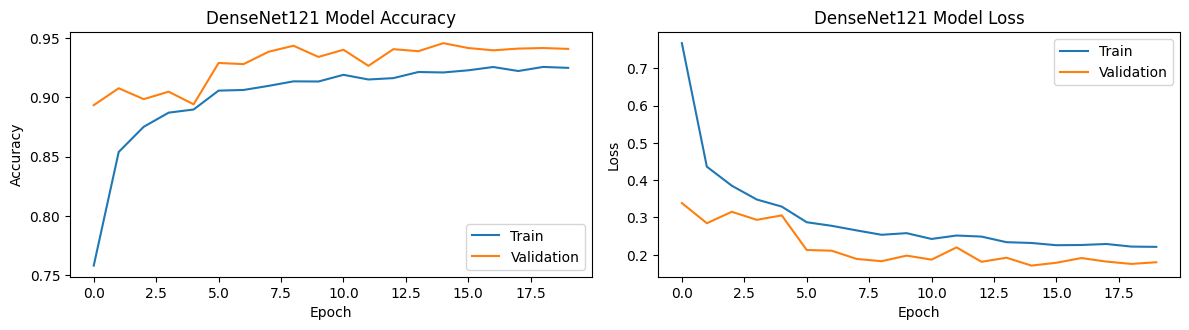

In [33]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 3)
plt.plot(DenseNet_History.history['accuracy']) 
plt.plot(DenseNet_History.history['val_accuracy'])
plt.title('DenseNet121 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(2, 2, 4)
plt.plot(DenseNet_History.history['loss'])
plt.plot(DenseNet_History.history['val_loss'])
plt.title('DenseNet121 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

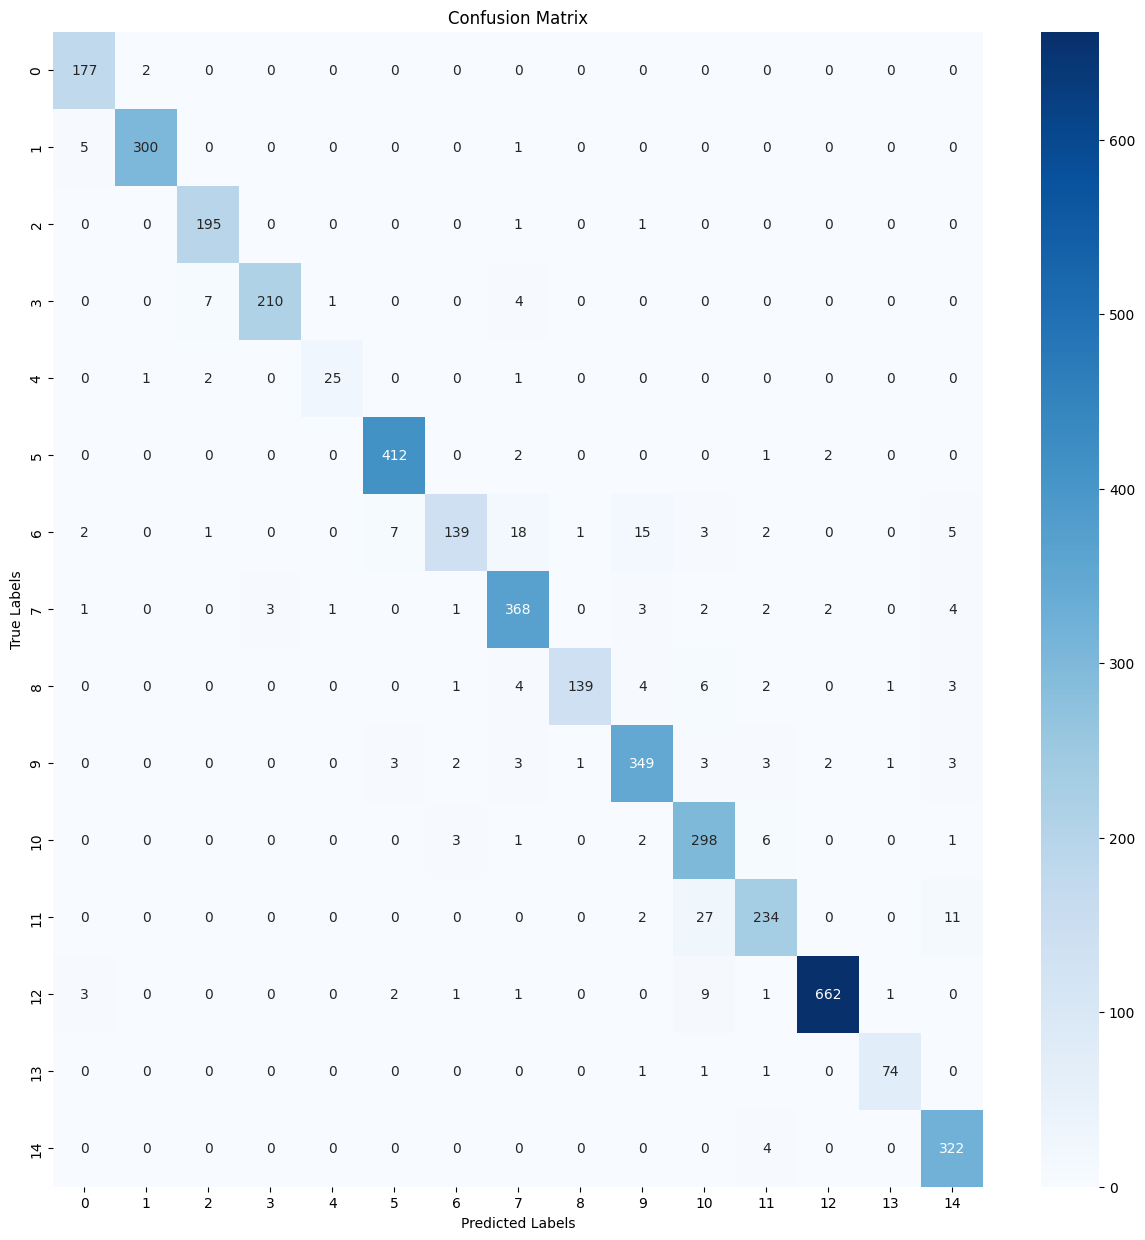

In [34]:
cm = confusion_matrix(y_val_encoded, y_pred_dense)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

*After evaluating both models, we notice the **DenseNet** is better*